In [ ]:
!git clone https://github.com/FaridRash/IGNIS

Cloning into 'IGNIS'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 99 (delta 32), reused 31 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 10.02 MiB | 4.49 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (9/9), done.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/IGNIS/Dataset/snr_dataset_gpu.csv')
print(df.head())

       Tg  theta       R  tau_a
0  283.15      0  460000    0.1
1  283.15      3  460000    0.1
2  283.15      6  460000    0.1
3  283.15      9  460000    0.1
4  283.15     12  460000    0.1


In [ ]:
df.shape

(1800000, 4)

In [ ]:
def GSD(h):
  return (h * 0.000012 / 0.0728) ** 2

In [ ]:
df['GSD'] = df['R'].apply(GSD)
print(df.head())
print(df.tail())

       Tg  theta       R  tau_a          GSD
0  283.15      0  460000    0.1  5749.305639
1  283.15      3  460000    0.1  5749.305639
2  283.15      6  460000    0.1  5749.305639
3  283.15      9  460000    0.1  5749.305639
4  283.15     12  460000    0.1  5749.305639
             Tg  theta       R  tau_a         GSD
1799995  370.15     75  153100   0.48  636.869007
1799996  370.15     78  153100   0.48  636.869007
1799997  370.15     81  153100   0.48  636.869007
1799998  370.15     84  153100   0.48  636.869007
1799999  370.15     87  153100   0.48  636.869007


In [ ]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [ ]:
Af = 10*10
Tf = 433.15
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8 / 1000
pixel = 12e-6
F_number = 1.05
D = (focal_length / F_number)

lambda_range = np.arange(8, 12.1, 0.1)
delta_lambda = 0.1

In [ ]:
def compute_snr_vectorized(df):
    Tg = df['Tg'].values[:, None]
    R = df['R'].values
    tau_a = df['tau_a'].values[:, None]
    theta = df['theta'].values
    GSD = df['GSD'].values

    Ag = GSD - Af
    cos_theta = np.cos(np.deg2rad(theta))

    lambda_ = lambda_range[None, :]

    # Planck radiation
    M_lambda_g = c1 / (lambda_**5 * (np.exp(c2 / (lambda_ * Tg)) - 1))
    M_lambda_f = c1 / (lambda_**5 * (np.exp(c2 / (lambda_ * Tf)) - 1))

    E_lambda_g = epsilon * M_lambda_g
    E_lambda_f = epsilon * M_lambda_f

    tau_factor = tau_a * tau_0 * eta * delta_lambda

    # Coefficients
    coeff_g = ((D**2 * t * cos_theta * Ag) / (4 * R**2 * h * c))[:, None]
    coeff_f = ((D**2 * t * cos_theta * Af) / (4 * R**2 * h * c))[:, None]

    S_lambda_g = coeff_g * (lambda_ * E_lambda_g * tau_factor)
    S_lambda_f = coeff_f * (lambda_ * E_lambda_f * tau_factor)

    S_Ag = np.sum(S_lambda_g, axis=1)
    S_Af = np.sum(S_lambda_f, axis=1)

    S_prime_g = S_Ag / Ag
    S_prime_f = S_Af / Af
    S_prime = S_prime_f - S_prime_g
    N_prime = np.sqrt(S_prime_f + S_prime_g)

    return S_prime / N_prime


In [ ]:
df['SNR'] = compute_snr_vectorized(df)

In [ ]:
chunks = np.array_split(df, 18)
snr_list = []
for i, chunk in enumerate(chunks):
    print(f"Processing chunk {i+1}")
    chunk['SNR'] = compute_snr_vectorized(chunk)
    snr_list.append(chunk)
df_final = pd.concat(snr_list, ignore_index=True)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing chunk 1
Processing chunk 2
Processing chunk 3
Processing chunk 4
Processing chunk 5
Processing chunk 6
Processing chunk 7
Processing chunk 8
Processing chunk 9
Processing chunk 10
Processing chunk 11
Processing chunk 12
Processing chunk 13
Processing chunk 14
Processing chunk 15
Processing chunk 16
Processing chunk 17
Processing chunk 18


In [ ]:
df_final.head()

,Tg,theta,R,tau_a,GSD,SNR
0,283.15,0,460000,0.1,5749.305639,239512.546772
1,283.15,3,460000,0.1,5749.305639,239348.368692
2,283.15,6,460000,0.1,5749.305639,238855.608446
3,283.15,9,460000,0.1,5749.305639,238033.582097
4,283.15,12,460000,0.1,5749.305639,236881.129772


In [ ]:
df_final.columns

Index(['Tg', 'theta', 'R', 'tau_a', 'GSD', 'SNR'], dtype='object')

In [ ]:
fig = px.scatter_3d(df.sample(10000), x='Tg', y='R', z='SNR',
                    color='SNR', title="SNR vs Tg and R")
fig.show()


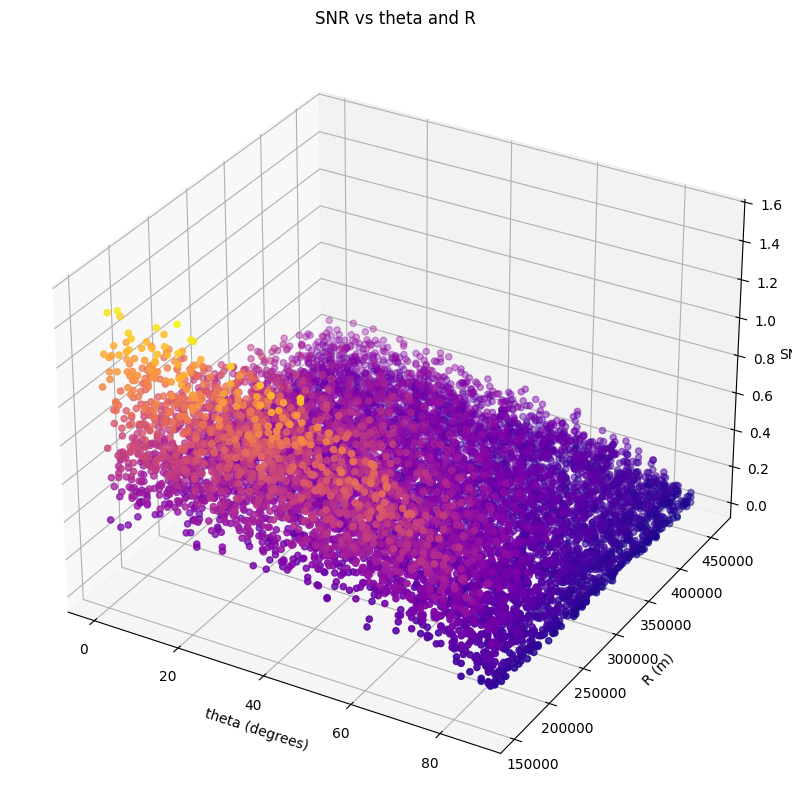

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['theta'], df_plot['R'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('theta (degrees)')
ax.set_ylabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs theta and R')
plt.show()


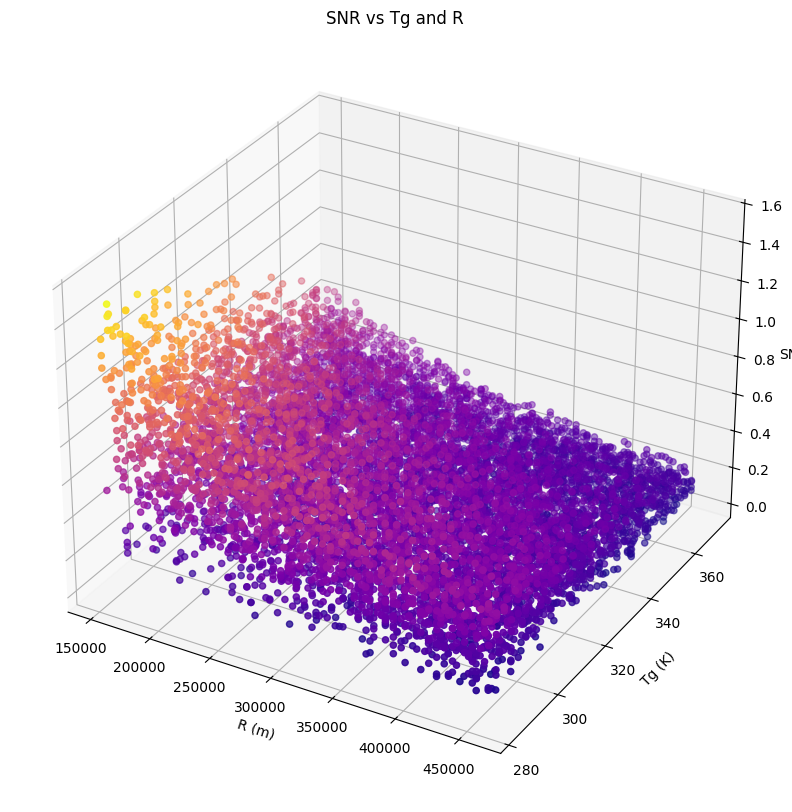

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter( df_plot['R'], df_plot['Tg'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_ylabel('Tg (K)')
ax.set_xlabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and R')
plt.show()

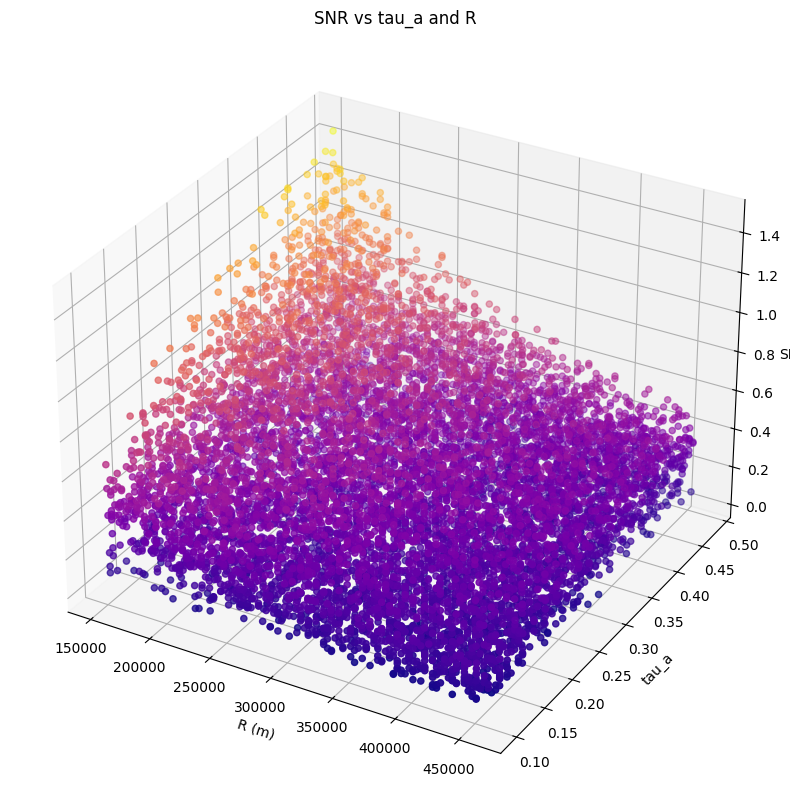

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['R'], df_plot['tau_a'] , df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_ylabel('tau_a')
ax.set_xlabel('R (m)')
ax.set_zlabel('SNR')
plt.title('SNR vs tau_a and R')
plt.show()

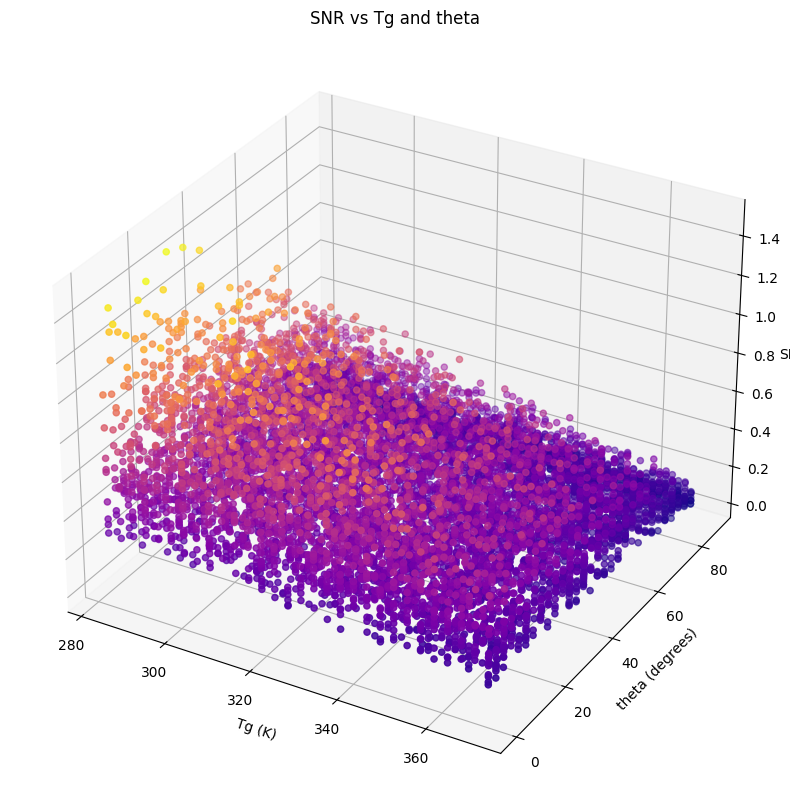

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['Tg'], df_plot['theta'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('Tg (K)')
ax.set_ylabel('theta (degrees)')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and theta')
plt.show()

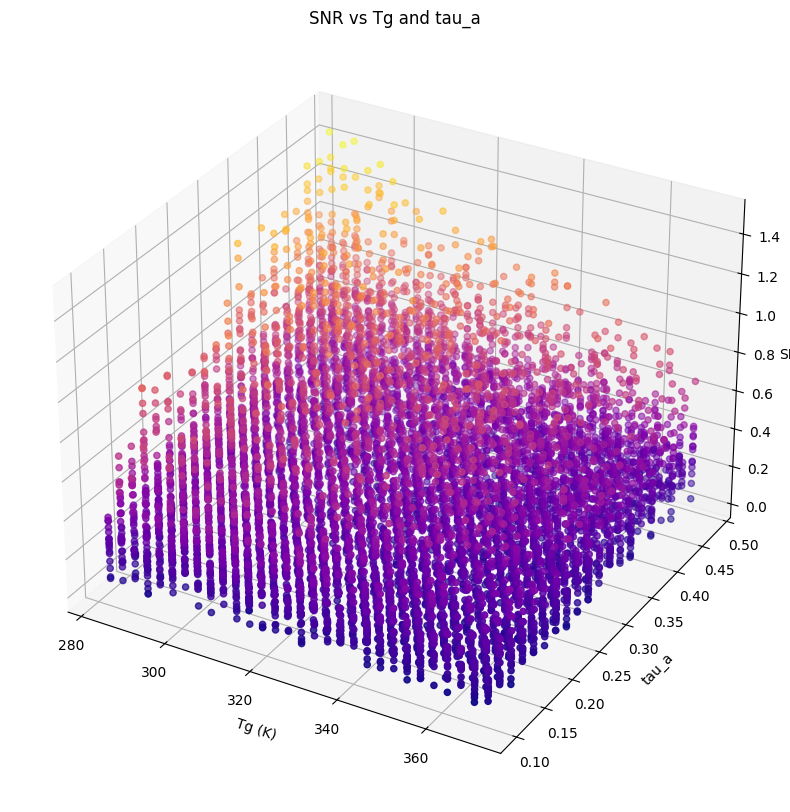

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['Tg'], df_plot['tau_a'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('Tg (K)')
ax.set_ylabel('tau_a')
ax.set_zlabel('SNR')
plt.title('SNR vs Tg and tau_a')
plt.show()

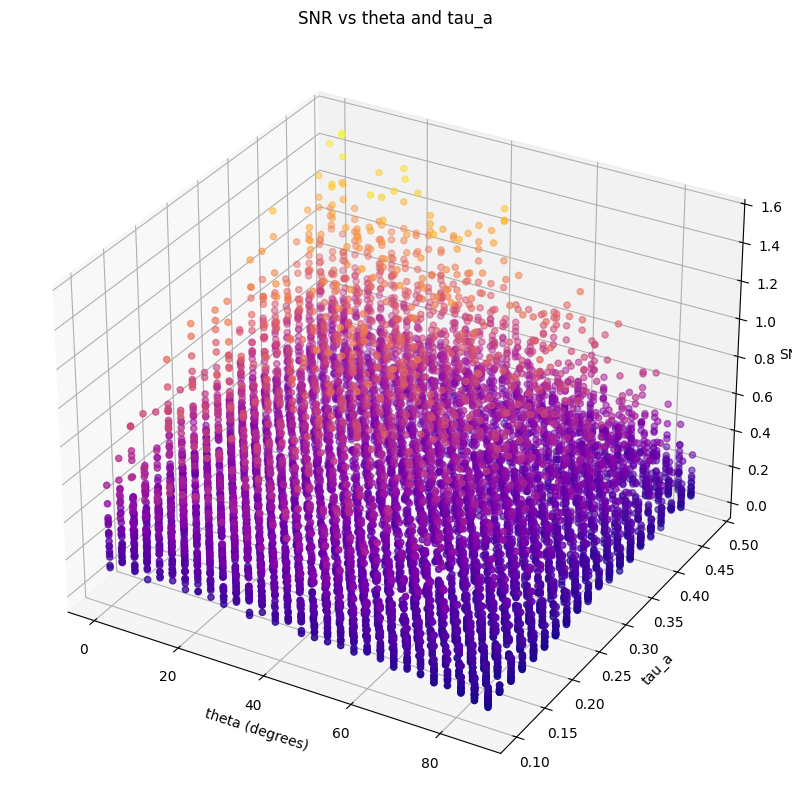

In [ ]:
df_plot = df.sample(10000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_plot['theta'], df_plot['tau_a'], df_plot['SNR'], c=df_plot['SNR'], cmap='plasma')
ax.set_xlabel('theta (degrees)')
ax.set_ylabel('tau_a')
ax.set_zlabel('SNR')
plt.title('SNR vs theta and tau_a')
plt.show()